### This notebook uses the Kaggle sarcastic news dataset and attempts to classify the news headlines provided in the dataset into the "normal" and "sarcastic" categories using various ML models.

Authors: 
- Sachin Peruri (sachin.peruri@gmail.com)
- Keyuri Raodeo (keyuri.raodeo@gmail.com)


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


We installed the following libraries on our Colab session-

- Pycaret: To run multiple ML models quickly on the data to determine which works best

- Pattern: We used this library to lemmatize our dataset. In our experience this worked better than other packages such as nltk and spacy.

- LightGBM: Light Gradient Boosting Model package was also used.

In [ ]:
pip install pycaret

In [ ]:
pip install pattern

In [ ]:
pip install lightgbm

In [ ]:
import json
import numpy as np
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
from nltk import word_tokenize

from pattern.en import lemma

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score


# Grid search
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pycaret
import pycaret
from pycaret.classification import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data_v2 = list(parse_data("/gdrive/MyDrive/Sarcastic_news/Sarcasm_Headlines_Dataset_v2.json"))

df = pd.DataFrame.from_dict(data_v2)

### Lets do some exploratory analysis

In [ ]:
len(df)

28619

In [ ]:
print(f"Max length: {df['headline'].apply(len).max()}, min length: {df['headline'].apply(len).min()}")

Max length: 926, min length: 7


(array([9.000e+00, 2.910e+02, 1.024e+03, 2.286e+03, 3.897e+03, 5.210e+03,
        6.135e+03, 4.707e+03, 2.642e+03, 1.308e+03, 6.420e+02, 2.940e+02,
        1.010e+02, 4.200e+01, 1.700e+01, 5.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200.]),
 <a list of 20 Patch objects>)

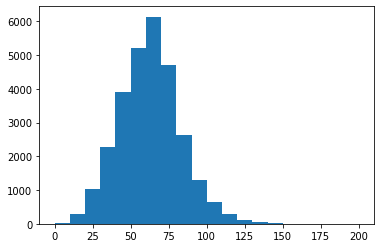

In [ ]:
plt.hist(df["headline"].apply(len), bins = 20, range = (0,200))

The headlines lengths seem to follow a normal distribution with a peak at around 60-70 characters long. The maximum sentence length is 926 and the minimum is 7.

In [ ]:
df.sample(5)

,is_sarcastic,headline,article_link
15717,0,13 #ridiculousexcusestostayhome -- boomer-style,https://www.huffingtonpost.com/entry/ridiculousexcusestostayhome-boomer-style_us_55a5268ae4b0b8145f738ea8
12379,1,"'i'm afraid you won't be coming to our new headquarters,' declares alexa as amazon execs find themselves locked in seattle office",https://www.theonion.com/i-m-afraid-you-won-t-be-coming-to-our-new-headquarters-1819580301
16304,1,holocaust survivors recall exact day holocaust started right out of the blue,https://www.theonion.com/holocaust-survivors-recall-exact-day-holocaust-started-1830685498
14063,0,"why christ, mao and the buddha are making a comeback in china",https://www.huffingtonpost.com/entry/china-religion_n_4860813.html
27987,1,state election commission chases wild animals out of voting booths in preparation for upcoming midterms,https://politics.theonion.com/state-election-commission-chases-wild-animals-out-of-vo-1829788634


### Data Cleaning

Now we shall clean the dataset by removing all characters except for letters and numbers and lemmatize the words using pattern library.

**NOTE: If this cell does not run in the first attempt, try running it again. This seems to be due to a bug in the pattern library.**

In [ ]:
clean_headlines = []

for headline in df["headline"]:
  clean_headlines.append(re.sub('[^A-Za-z]+', ' ', headline))

lemmatized_out = [[lemma(word) for word in word_tokenize(s)] for s in clean_headlines]

joined_headlines = []

for headline in lemmatized_out:
  joined_headlines.append(" ".join(headline))

In [ ]:
df["headline"][:2]

0                      thirtysomething scientists unveil doomsday clock of hair loss
1    dem rep. totally nails why congress is falling short on gender, racial equality
Name: headline, dtype: object

In [ ]:
joined_headlines[:2]

['thirtysomethe scientist unveil doomsday clock of hair los',
 'dem rep totally nail why congres be fall short on gender racial equality']

Our target variable is the "is_sarcastic" column.

In [ ]:
y = df["is_sarcastic"]

### Making the train and test dataset splits

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(joined_headlines,y,test_size=0.25,random_state=0)

In [ ]:
vectorizer = TfidfVectorizer(stop_words = "english", max_features = 10000)
X_train_matrix = vectorizer.fit_transform(X_train)
X_test_matrix = vectorizer.transform(X_test)

### Reducing the number of features in the dataset down to 20 from 10,000 using NMF (Non-Negative Matrix Factorization) to speed up training

In [ ]:
nmf_reducer = NMF(n_components = 20)
X_train_reduced = nmf_reducer.fit_transform(X_train_matrix)
X_test_reduced = nmf_reducer.transform(X_test_matrix)

In [ ]:
vectorizer2 = TfidfVectorizer(stop_words = "english", max_features = 10000)
X_full = vectorizer2.fit_transform(joined_headlines)

In [ ]:
X_full[:5]

<5x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 32 stored elements in Compressed Sparse Row format>

In [ ]:
# Reduce X_full to 20D using NMF as well
nmf_reducer2 = NMF(n_components = 20)
X_full_reduced = nmf_reducer2.fit_transform(X_full)

In [ ]:
X_full_reduced = pd.DataFrame(X_full_reduced)
X_full_reduced["is_sarcastic"] = y

In [ ]:
X_full_reduced.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,is_sarcastic
0,0.000000,0.000000,0.010154,0.000000,0.001882,0.000861,0.000742,0.000000,0.000000,0.001500,0.000000,0.001103,0.002623,0.002257,0.001690,0.000412,0.002299,0.000761,0.000799,0.000698,1
1,0.000602,0.001519,0.000120,0.002773,0.000940,0.000333,0.000407,0.000454,0.000433,0.000313,0.002461,0.001281,0.001366,0.001078,0.000000,0.002380,0.001348,0.004623,0.004098,0.003129,0
2,0.001544,0.000000,0.000372,0.002603,0.000000,0.000184,0.003489,0.001828,0.000074,0.004187,0.000000,0.000578,0.003028,0.002024,0.004375,0.000507,0.000000,0.000000,0.002570,0.001147,0
3,0.000000,0.000084,0.002669,0.004563,0.000000,0.003223,0.001574,0.000000,0.000000,0.011074,0.000000,0.004177,0.000000,0.000000,0.002207,0.009289,0.003509,0.000000,0.000605,0.001991,1
4,0.001381,0.001217,0.003483,0.000471,0.001650,0.003517,0.002743,0.001265,0.000581,0.020214,0.002261,0.004953,0.003000,0.002113,0.005501,0.001471,0.000467,0.002051,0.000268,0.006729,1


### Comparing ML models with Pycaret and NMF reduced dataset

In [ ]:
# setup the dataset
grid = setup(data=X_full_reduced, target="is_sarcastic", silent = True, verbose = False, pca = False)

In [ ]:
# Tfidf vectorizer, 10000 features + NMF -> 20 features
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6957,0.7666,0.6538,0.6908,0.6717,0.3885,0.3891,0.585
rf,Random Forest Classifier,0.6899,0.7586,0.6339,0.6898,0.6606,0.3760,0.3772,5.232
gbc,Gradient Boosting Classifier,0.6866,0.7571,0.6288,0.6868,0.6564,0.3693,0.3706,6.972
et,Extra Trees Classifier,0.6858,0.7542,0.6305,0.6851,0.6566,0.3680,0.3691,2.683
ada,Ada Boost Classifier,0.6702,0.7378,0.6323,0.6609,0.6462,0.3376,0.3380,1.561
knn,K Neighbors Classifier,0.6443,0.6926,0.6136,0.6300,0.6216,0.2861,0.2862,1.839
ridge,Ridge Classifier,0.6229,0.0000,0.3858,0.6850,0.4935,0.2288,0.2529,0.037
lda,Linear Discriminant Analysis,0.6204,0.7011,0.3719,0.6879,0.4826,0.2230,0.2494,0.088
lr,Logistic Regression,0.6140,0.6926,0.3496,0.6861,0.4631,0.2087,0.2378,0.387
dt,Decision Tree Classifier,0.6090,0.6084,0.5972,0.5882,0.5926,0.2168,0.2168,0.372


Looks like Light Gradient Boosting Machine or LGBM performs the best

Custom function to display detailed confusion matrices

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Custom function to run different ML models in one go and compare results

In [ ]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
  '''
  Lightweight script to test many models and find winners
  :param X_train: training split
  :param y_train: training target vector
  :param X_test: test split
  :param y_test: test target vector
  :return: DataFrame of predictions
  '''
  dfs = []
  models = [
            ('LogReg', LogisticRegression()), 
            ('RF', RandomForestClassifier()),
            #('KNN', KNeighborsClassifier()),
            #('SVM', SVC()), 
            #('GNB', GaussianNB()),
            #('XGB', XGBClassifier()),
            ('LGBM', LGBMClassifier()),
            ('GBC', GradientBoostingClassifier()),
            #('ADA', AdaBoostClassifier()),
            ('ETC', ExtraTreesClassifier())
          ]
  results = []
  names = []
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
  target_names = ['normal', 'sarcastic']
  for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score =True)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(name)
    print(cnf_matrix)
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['Zero', 'One']
    make_confusion_matrix(cnf_matrix, group_names=labels, categories=categories, title = name)
    print("\n")

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
  
  final = pd.concat(dfs, ignore_index=True)

  return final

### Running all models using NMF reduced datasets

LogReg
[[3242  566]
 [2079 1268]]
              precision    recall  f1-score   support

      normal       0.61      0.85      0.71      3808
   sarcastic       0.69      0.38      0.49      3347

    accuracy                           0.63      7155
   macro avg       0.65      0.62      0.60      7155
weighted avg       0.65      0.63      0.61      7155



RF
[[2825  983]
 [1208 2139]]
              precision    recall  f1-score   support

      normal       0.70      0.74      0.72      3808
   sarcastic       0.69      0.64      0.66      3347

    accuracy                           0.69      7155
   macro avg       0.69      0.69      0.69      7155
weighted avg       0.69      0.69      0.69      7155



LGBM
[[2798 1010]
 [1153 2194]]
              precision    recall  f1-score   support

      normal       0.71      0.73      0.72      3808
   sarcastic       0.68      0.66      0.67      3347

    accuracy                           0.70      7155
   macro avg       0.70     

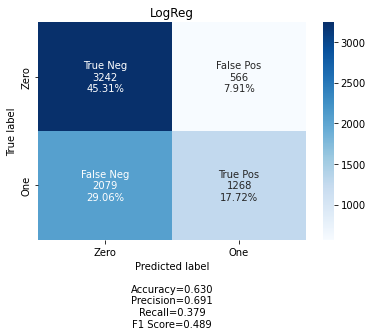

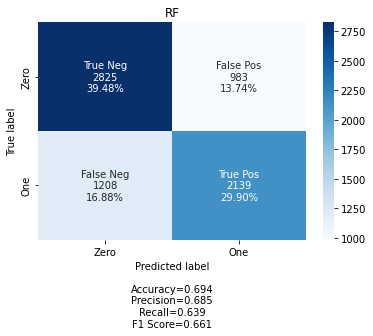

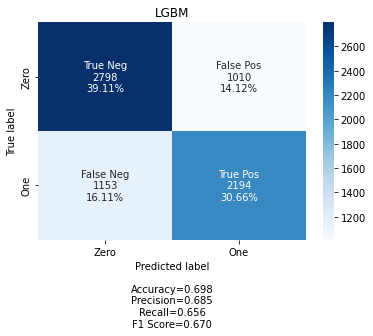

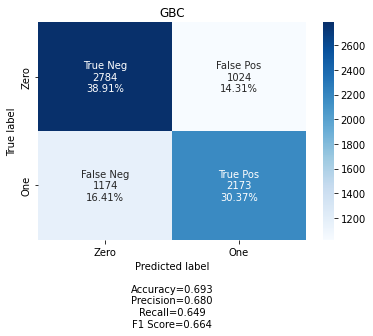

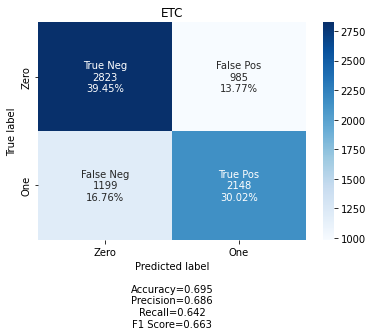

In [ ]:
final_df = run_exps(X_train_reduced, y_train, X_test_reduced, y_test)

Looks like LGBM performs the best on the reduced datasets with an F1 score of **0.67**

Defining custom pipeline to perform a grid search to find best parameters for LGBM model

In [ ]:
# Build our pipeline
pipeline = Pipeline([
    ('vectoriser', TfidfVectorizer()),
    ('decomposer', NMF(n_components=20)),
    ('classifier', #LogisticRegression(penalty = "l1", solver = 'saga'),
     LGBMClassifier(n_estimators = 100, max_depth = 3)),
     #RandomForestClassifier(n_estimators = 200, max_depth = 3, n_jobs = 4)
     #),
])

# Define our parameter grid
params = {
    "vectoriser": [TfidfVectorizer()],
    "vectoriser__max_features" : [5000],
    "decomposer__n_components" : [10, 20, 25],
    "classifier__n_estimators" : [100, 200, 300],
    "classifier__max_depth" : [3,4,5] ,
}

gridsearch = GridSearchCV(pipeline, params)

In [ ]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectoriser',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                 

### After grid search using the LGBM model, the best accuracy found was 0.763

In [ ]:
gridsearch.best_score_

0.7630915452429223

In [ ]:
gridsearch.cv_results_

{'mean_fit_time': array([3.55637245, 3.93389969, 8.58552752, 3.52774014, 3.93955441,
        7.93978248, 3.6839057 , 3.80588751, 6.64989753, 3.58306007,
        3.59984374, 8.01427345, 3.77312202, 4.9354528 , 7.36260953,
        3.90268936, 4.86375484, 7.58627334, 3.46912098, 5.89221792,
        7.45064898, 3.90488067, 4.29146194, 7.96254096, 4.08712234,
        4.57862625, 7.07678947]),
 'mean_score_time': array([0.09123106, 0.11117778, 0.11625981, 0.12716541, 0.13236313,
        0.1321878 , 0.12539787, 0.13752556, 0.15798659, 0.09764853,
        0.11305814, 0.11781225, 0.10793076, 0.12520061, 0.13264198,
        0.13114872, 0.15283875, 0.162886  , 0.09845929, 0.11186533,
        0.11479373, 0.12459826, 0.13906894, 0.16095929, 0.15246363,
        0.15228081, 0.17337489]),
 'mean_test_score': array([0.73155043, 0.75037255, 0.75493864, 0.73634938, 0.75451932,
        0.75871207, 0.73644262, 0.75512478, 0.76108819, 0.73574352,
        0.75391333, 0.75670864, 0.73825958, 0.75810668, 0.762

In [ ]:
gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('vectoriser',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=5,
                                min_child_samples=20, min_child_weight=0.001,
        

In [ ]:
gridsearch.predict(X_test)

array([1, 0, 1, ..., 0, 0, 0])

### **Precision**: How accurate is the classifier i.e. how many of the predicted positivies are actually true positives
### **Recall**: How much of the actual true positives did the classifier catch i.e. of all the true positives how many did the classifier catch

### Trying out Simple logistic regression with full, unreduced dataset

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# 
y_pred=logreg.predict(X_test)


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

In [ ]:
cnf_matrix

array([[3006,  802],
       [ 985, 2362]])

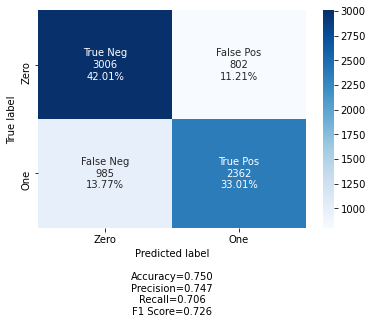

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cnf_matrix, 
                      group_names=labels,
                      categories=categories)

Best accuracy using plain logistic regression and the unreduced dataset was found to be 0.75, precision was 0.747 and F1-score was 0.726

Now we shall test out all the models once again using the full dataset to see the difference NMF reduction causes

In [ ]:

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
  '''
  Lightweight script to test many models and find winners
  :param X_train: training split
  :param y_train: training target vector
  :param X_test: test split
  :param y_test: test target vector
  :return: DataFrame of predictions
  '''
  dfs = []
  models = [
            ('LogReg', LogisticRegression()), 
            ('RF', RandomForestClassifier()),
            ('KNN', KNeighborsClassifier()),
            ('SVM', SVC()), 
            #('GNB', GaussianNB()),
            ('XGB', XGBClassifier()),
            ('LGBM', LGBMClassifier()),
            ('GBC', GradientBoostingClassifier()),
            ('ADA', AdaBoostClassifier()),
            ('ETC', ExtraTreesClassifier())
          ]
  results = []
  names = []
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
  target_names = ['normal', 'sarcastic']
  for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score =True)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))
    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
  
  final = pd.concat(dfs, ignore_index=True)

  return final

In [ ]:
final_df = run_exps(X_train , y_train, X_test, y_test)

LogReg
              precision    recall  f1-score   support

      normal       0.75      0.79      0.77      3808
   sarcastic       0.75      0.71      0.73      3347

    accuracy                           0.75      7155
   macro avg       0.75      0.75      0.75      7155
weighted avg       0.75      0.75      0.75      7155

RF
              precision    recall  f1-score   support

      normal       0.74      0.77      0.76      3808
   sarcastic       0.73      0.70      0.71      3347

    accuracy                           0.74      7155
   macro avg       0.74      0.73      0.73      7155
weighted avg       0.74      0.74      0.74      7155

KNN
              precision    recall  f1-score   support

      normal       0.63      0.74      0.68      3808
   sarcastic       0.63      0.50      0.55      3347

    accuracy                           0.63      7155
   macro avg       0.63      0.62      0.62      7155
weighted avg       0.63      0.63      0.62      7155

SVM
 

Overall, looks like the performance increases by a few percentage points across all metrics when we use the un-reduced dataset as expected.

While the **maximum F1-score achievable with the reduced dataset was 0.72, with the un-reduced dataset it rises to 0.78**; which is a considerable increase.

Another point to note is that the **sarcastic class has lower recall metrics across the board, regardless of model used**. For example for Logistic Regression using the full dataset, "normal" category has 0.79 recall whereas "sarcastic" category has only 0.71 as the recall. 

This may be due to the complex and sometimes inconsistent nature of sarcasm used, which would indeed be hard for the more simpler ML models to decipher.

Overall, we seem to hit an **upper ceiling of 0.78 F1-score** with around **0.75 precision and recall with traditional ML models**.

### To continue exploring the best ML model for this task, we move towards Deep Learning methods such as neural networks using Keras and using Transformers from the Huggingface library in the subsequent DL notebook.

****END****